In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [3]:
df = pd.read_csv('CN_DB.csv')
df.columns

Index(['suject_id', 'timestamp', 'season', 'city', 'climate', 'building_type',
       'heating_type', 'gender', 'age', 'ht', 'wt', 'thermal_sensation',
       'thermal_comfort', 'thermal_acceptability', 'clo', 'met', 'ta', 'rh',
       'vel', 'tg', 'top', 'tr', 't_out_min', 't_out_monthly', 'latitude'],
      dtype='object')

In [4]:
# calcualte the mean values for each city
# group by city, using mean values
df_city = df.groupby('city').agg(
    records=('city', 'size'),
    thermal_sensation=('thermal_sensation', 'mean'),
    ta=('ta', 'mean'),
    top=('top', 'mean'),
    tg=('tg', 'mean'),
    clo=('clo', 'mean'),
    latitude=('latitude', 'mean'),
).reset_index()

In [5]:
df_city.head()

,city,records,thermal_sensation,ta,top,tg,clo,latitude
0,Baotou,303,0.016502,19.766997,19.277228,19.180198,0.341782,40.65
1,Beijing,651,-0.027957,22.948541,22.066052,22.468971,0.920568,39.90
2,FujianFuzhou,7,-0.714286,18.100000,18.100000,18.100000,0.351429,26.08
3,FujianNanping,4,0.000000,17.900000,17.900000,17.900000,0.417500,26.64
4,FujianZhenjiang,2,-0.500000,22.900000,22.900000,22.900000,0.305000,26.10


## calcualte the neutral temperature for each city using three methods

In [6]:
def regression_a(df):
    """
    thermal_sensation = a * top + b
    Regressing Thermal Sensation Vote (thermal_sensation) against indoor operative temperature (top).    
    Use the regression model to derive the neutral temperature by letting thermal_sensation equals 0.
    The upper and lower limit of 80% comfort zone are derived by letting thermal_sensation equals +-0.85.
    """
    lm_result = smf.ols(formula='thermal_sensation ~ top', data=df).fit()
    slope = lm_result.params['top']
    intercept = lm_result.params['Intercept']
    # check whether the slope is significant
    if lm_result.pvalues['top'] < 0.05:
        a = slope
        b = intercept
        tn = -b / a
        tup = (0.85-b)/a
        tlow = (-0.85-b)/a
        comfz = tup - tlow
        return [tn, comfz]
    else:
        return [np.nan] * 2  # Return NaNs if the slope is not significant

def regression_b(df):
    """
    top = a * thermal_sensation + b
    Regressing indoor operative temperature (top) against thermal_sensation.
    Use the regression model to derive the neutral temperature by letting thermal_sensation equals 0.
    The upper and lower limit of 80% comfort zone are derived by letting thermal_sensation equals +-0.85.
    """
    lm_result = smf.ols(formula='top ~ thermal_sensation', data=df).fit()
    slope = lm_result.params['thermal_sensation']
    intercept = lm_result.params['Intercept']
    # check whether the slope is significant
    if lm_result.pvalues['thermal_sensation'] < 0.05:
        a = slope
        b = intercept
        tn = b
        tup = 0.85*a + b
        tlow = (-0.85)*a + b
        comfz = tup - tlow
        return [tn, comfz]
    else:
        return [np.nan] * 2
    
def griffiths(df):
    # Nicol, Fergus, and Michael Humphreys. “Derivation of the Adaptive Equations for Thermal Comfort in Free-Running Buildings in European Standard EN15251.” Building and Environment, International Symposium on the Interaction between Human and Building Environment Special Issue Section, 45, no. 1 (January 1, 2010): 11–17. https://doi.org/10.1016/j.buildenv.2008.12.013.
    # Griffths I. Thermal comfort studies in buildings with passive solar features, field studies. UK: Report of the Commission of the European Community, ENS35 090; 1990.
    # Tcomf = Tg - C / G, c as comfort vote and G as griffiths constatnt
    tn = df['tg'] - df['thermal_sensation'] / 0.4
    return tn


In [7]:
# apply regression_a to df for each city and store the results in the df_city
result = df.groupby('city').apply(regression_a)
df_result = pd.DataFrame(result.tolist(), index=result.index, columns=['tn_a', 'comfz_a'])
df_city = df_city.merge(df_result, left_on='city', right_index=True, how='left')

# apply regression_b to df for each city and store the results in the df_city
result = df.groupby('city').apply(regression_b)
df_result = pd.DataFrame(result.tolist(), index=result.index, columns=['tn_b', 'comfz_b'])
df_city = df_city.merge(df_result, left_on='city', right_index=True, how='left')
df_city

# directly apply griffiths to df for each city and store the results in the df_city
df_city['tn_g'] = df_city['tg'] - df_city['thermal_sensation'] / 0.4

## Likelihood of Central Heating by City


In [8]:
# check the heating_type unique values
print(df['heating_type'].unique())

['Radiator heating' 'Convection heating' 'Radiant floor heating'
 'Naturally Ventilated' 'Ceiling capillary heating'
 'Air conditioning heating' 'Others' 'self-heating' 'Furnace heating'
 'Floor radiation + fan coil' 'Small electric heater heating']


In [9]:
# calcualte the percentage of Radiator heating for each city and assign the value to df_city
df_city['p_dh'] = df_city['city'].apply(lambda x: df[df['city'] == x]['heating_type'].value_counts().get('Radiator heating', 0) / df[df['city'] == x]['heating_type'].count())

In [10]:
# resort the df_city by latitude
df_city = df_city.sort_values(by='latitude')
# reset the index
df_city = df_city.reset_index(drop=True)
df_city

,city,records,thermal_sensation,ta,top,tg,clo,latitude,tn_a,comfz_a,tn_b,comfz_b,tn_g,p_dh
0,HainanSanya,5,0.600000,24.880000,24.880000,24.880000,0.332000,18.25,NaN,NaN,NaN,NaN,23.380000,0.000000
1,GuangdongGuangzhou,997,-0.013039,23.850150,23.876128,23.879338,0.859910,23.13,24.011192,17.609175,23.877979,0.241278,23.911936,0.000000
2,YunnanKunming,415,-1.154217,13.617108,13.617108,19.218182,0.647133,24.87,19.973323,9.361815,15.276200,2.443609,22.103724,0.000000
3,FujianFuzhou,7,-0.714286,18.100000,18.100000,18.100000,0.351429,26.08,NaN,NaN,NaN,NaN,19.885714,0.000000
4,FujianZhenjiang,2,-0.500000,22.900000,22.900000,22.900000,0.305000,26.10,NaN,NaN,NaN,NaN,24.150000,0.000000
5,FujianNanping,4,0.000000,17.900000,17.900000,17.900000,0.417500,26.64,NaN,NaN,NaN,NaN,17.900000,0.000000
6,HunanHengyang,1,-1.000000,16.900000,16.900000,16.900000,0.660000,26.89,NaN,NaN,NaN,NaN,19.400000,0.000000
7,HunanChangsha,1108,-0.396029,17.222563,17.413267,18.198544,0.947500,28.23,21.354007,16.916082,18.090188,2.905762,19.188616,0.000000
8,SichuanZigong,23,-0.217391,11.026087,11.026087,11.026087,1.586522,29.34,11.535972,3.987298,11.141860,0.905349,11.569565,0.000000
9,Lhasa,355,-1.095775,10.640845,10.640845,10.640845,1.253380,29.65,20.975146,16.032777,12.117684,2.291188,13.380282,0.005634


## Check p_heating values and update unreasonable ones

Text(0, 0.5, 'probability of district heating')

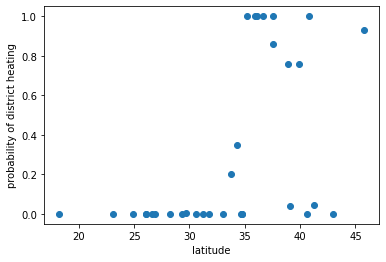

In [11]:
# scatter plot the probability of district heating across latitude
plt.scatter(df_city['latitude'], df_city['p_dh'])
plt.xlabel('latitude')
plt.ylabel('probability of district heating')

In [12]:
# print each city name using a for loop
for i in range(len(df_city)):
    if i >= 10:
        cityname = df_city['city'][i]
        print(cityname)
        print(df_city['p_dh'][i])
        print(df[df['city'] == cityname]['heating_type'].value_counts())
        print(df[df['city'] == cityname]['building_type'].value_counts())
        print("***************************************\n")
        print()

HubeiWuhan
0.0
Naturally Ventilated    526
Name: heating_type, dtype: int64
Dormitory       348
Residential      95
Educationnal     83
Name: building_type, dtype: int64
***************************************


Shanghai
0.0
Convection heating               784
Radiant floor heating            726
Naturally Ventilated             390
Air conditioning heating         200
Small electric heater heating     23
Others                             8
Name: heating_type, dtype: int64
Office         906
Residential    858
Educational    315
Dormitory       52
Name: building_type, dtype: int64
***************************************


JiangsuChangzhou
0.0
Ceiling capillary heating    144
Name: heating_type, dtype: int64
Residential    144
Name: building_type, dtype: int64
***************************************


HenanNanyang
0.0
Naturally Ventilated        155
Air conditioning heating     96
Name: heating_type, dtype: int64
Residential    251
Name: building_type, dtype: int64
*******************

In general, the "Radiator heating" should indicate central heating systems.</br>
However, for Northern cities, the "Raidiant floor heating", "Floor radiation + fan coil" should also indicate central heating systems.

In [13]:
# Include Radiant floor heating as central heating
df_city.loc[df_city['city'] == "ShaanxiXi'an", 'p_dh'] = (594+585) / 1686
# Include Radiant floor heating as central heating
df_city.loc[df_city['city'] == "HenanZhengzhou", 'p_dh'] = 4 / 96
# Include Radiant floor heating as central heating
df_city.loc[df_city['city'] == 'LiaoningDalian', 'p_dh'] = (1292+67) / (1292+278+67+58+8)
# Include (floor heating + fan coil) as central heating
df_city.loc[df_city['city'] == 'Tianjin', 'p_dh'] = (684+31)/(684+31+15)
# Wrong data, http://dx.doi.org/10.1016/j.enbuild.2015.12.053
df_city.loc[df_city['city'] == 'Baotou', 'p_dh'] = 1
# Include Radiant floor heating as central heating
df_city.loc[df_city['city'] == 'LiaoningBenxi', 'p_dh'] = 1
# Include Radiant floor heating as central heating
df_city.loc[df_city['city'] == 'HeilongjiangHarbin', 'p_dh'] = 1

Text(0, 0.5, 'probability of district heating')

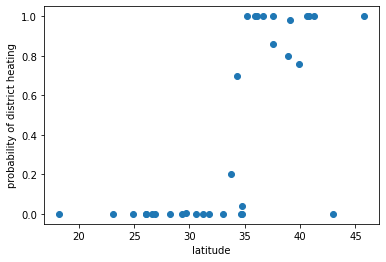

In [14]:
# scatter plot the probability of district heating across latitude
plt.scatter(df_city['latitude'], df_city['p_dh'])
plt.xlabel('latitude')
plt.ylabel('probability of district heating')

## Export CSV

In [15]:
# for all values in df_city, only keep two decimal places
df_city = df_city.round(2)
# save the df_city to a csv file
df_city.to_csv('CN_DB_CITY.csv', index=False)